In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
%load_ext autoreload
%autoreload 2

# this line ensures that all models will have the same split
np.random.seed(1882)

In [2]:
XY = np.loadtxt('phishing.data', delimiter=',')
XY = XY.astype(np.int8)
df = pd.DataFrame(XY, columns=[f'x{i}' for i in range(0, XY.shape[1] - 1)] + ['y'])

In [3]:
print(f'Number of NANs:\n{df.isna().sum().sum()}')

Number of NANs:
0


Tym razem nie będziemy, patrzeć w dane.  
Ostatnio spędziłem nad tym dużo czasu, żeby nie wyciągnąć żadnych wniosków.  
Nasze algorytmy i problemy stały się zbyt złożone, żeby można było je ładnie narysować :(  

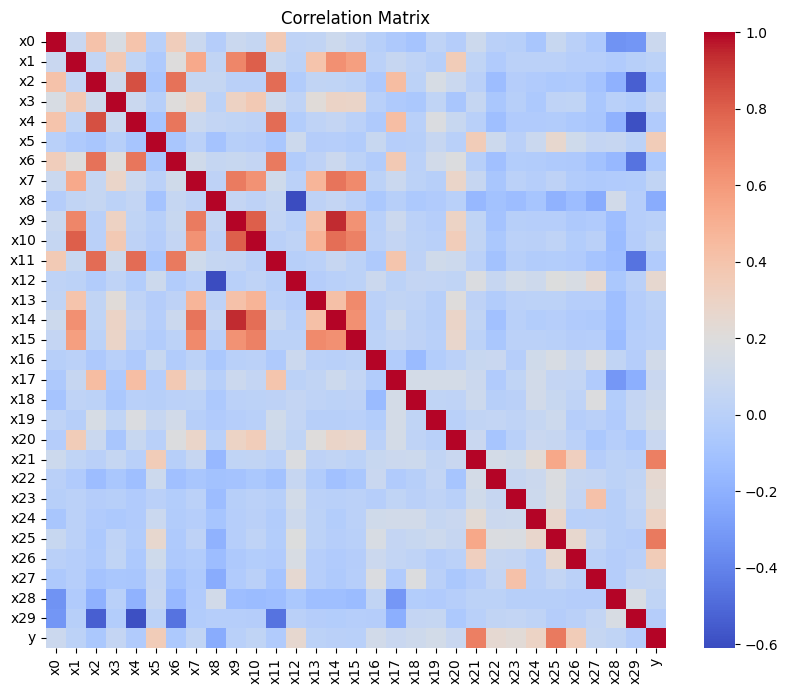

In [4]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

Przyznaje się popatrzyłem w dane, ale tylko dlatego, żeby być może usunać pewne nieistotne cechy

In [5]:
important_features_df = correlation_matrix['y'].abs().sort_values(ascending=False)
print(f'Features sorted by importance:\n{important_features_df}')

Features sorted by importance:
y      1.000000
x25    0.714741
x21    0.692935
x5     0.348606
x26    0.346103
x24    0.298323
x12    0.253372
x22    0.248229
x8     0.225789
x23    0.221419
x19    0.128950
x16    0.121496
x18    0.104645
x0     0.094160
x20    0.079857
x17    0.075718
x2     0.067966
x6     0.060488
x27    0.057430
x3     0.052948
x7     0.041838
x11    0.039854
x4     0.038608
x10    0.036419
x28    0.032574
x29    0.020113
x1     0.018249
x13    0.012653
x15    0.003394
x9     0.000280
x14    0.000086
Name: y, dtype: float64


In [6]:
important_features_idx = np.array([30, 25, 21, 5, 26, 24, 12, 22, 8, 23])
XY_reduced = XY[:, important_features_idx]

In [7]:
from src.utilz import get_random_splits

datasets = get_random_splits(XY_reduced, [0.6, 0.2, 0.2], T = 10)

In [8]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

sk_svm = SVC()
sk_svm.fit(datasets[0][0][:, :-1], datasets[0][0][:, -1])
y_pred = sk_svm.predict(datasets[0][1][:, :-1])
print(f'Reduced feature set accuracy: {accuracy_score(datasets[0][1][:, -1], y_pred)}')


Reduced feature set accuracy: 0.7638009049773755


Jak widzimy cechy jednak są istotne :(  
Tu był bug, bez -1  
Ale nadal średnio, hmm...

In [9]:
from src.utilz import get_random_splits

datasets = get_random_splits(XY, [0.6, 0.2, 0.2], T = 10)

Bardzo ważna uwaga. Nierealne jest wytrenować SVM bazując tylko na odchyle od rozwiązania optymalnego.  
Mi liczyło się 2h i nawet nie przeszło 1 epoki.  
Sklearn chyba robi to na GPU i pewnie robi to z lepszymi heurystykami niż ja :(  
Zostaję przy twardym limicie pomiędzy 1k-10k epok

In [10]:
from src.svm import SVM_SMO
from src.kernels import LinearKernel

svm_smo = SVM_SMO(C=0.5, epochs=1000, kernel=LinearKernel())
svm_smo.fit(datasets[0][0][:, :-1], datasets[0][0][:, -1].reshape(-1, 1))
print(f'Accuracy: {svm_smo.accuracy(datasets[0][1][:, :-1], datasets[0][1][:, -1].reshape(-1, 1))}')


Training...
Number of support vectors:  901
Accuracy: 0.8764705882352941


Liczenie predykcji forem jest bardzo wolne  
Na razie nie wiem jak to zwektoryzować :(  
Pomysł jest taki
- wyrzucić wszystko co ma alpha=0, będzie mniej mnożeń
- zwektoryzowac kernel

Udało się, jest szybko, ale kernel gaussowski nie daje dobrych efektów,  
chyba to przez to, że dane są dyskretne i słabo separuje

No nie, jednak bardzo źle liczyłem accuracy. Wszystko śmiga.  
Pomyłka w wymiarach kosztowała mnie 5h :(

Robimy szybki dobór hiperparametrów na 1000 epokach  
To starcza do przyzwoitej zbieżności

In [15]:
from src.svm import SVM_SMO
from src.kernels import LinearKernel
from src.measures import average_error_val

svm_smo_0 = SVM_SMO(C=5.0, epochs=1000, kernel=LinearKernel(), silent=True)
svm_smo_1 = SVM_SMO(C=1.0, epochs=1000, kernel=LinearKernel(), silent=True)
svm_smo_2 = SVM_SMO(C=0.1, epochs=1000, kernel=LinearKernel(), silent=True)
svm_smo_3 = SVM_SMO(C=0.10, epochs=1000, kernel=LinearKernel(), silent=True)

svm0_val_error, _ = average_error_val(svm_smo_0, datasets)
svm1_val_error, _ = average_error_val(svm_smo_1, datasets)
svm2_val_error, _ = average_error_val(svm_smo_2, datasets)
svm3_val_error, _ = average_error_val(svm_smo_3, datasets)

print(f'Average validation error for SVM SMO with C=5.0: {svm0_val_error}')
print(f'Average validation error for SVM SMO with C=1.0: {svm1_val_error}')
print(f'Average validation error for SVM SMO with C=0.1: {svm2_val_error}')
print(f'Average validation error for SVM SMO with C=0.01: {svm3_val_error}')


Average validation error for SVM SMO with C=5.0: 0.13723981900452487
Average validation error for SVM SMO with C=1.0: 0.1304524886877828
Average validation error for SVM SMO with C=0.1: 0.13737556561085973
Average validation error for SVM SMO with C=0.01: 0.13737556561085973


Wytrenujmy model, dla C = 1

In [17]:
from src.svm import SVM_SMO
from src.kernels import LinearKernel
from src.measures import average_error

svm_smo = SVM_SMO(C=1.0, epochs=5000, kernel=LinearKernel(), silent=True)
svm_test_error, svm_train_error = average_error(svm_smo, datasets)

Bez ładnego testu - średni czas uczenia wyniósł 4.8s dla 5000 epok

In [18]:
print(f'Average test error for SVM SMO with C=1.0: {svm_test_error}')
print(f'Average train error for SVM SMO with C=1.0: {svm_train_error}')

Average test error for SVM SMO with C=1.0: 0.13190239493899686
Average train error for SVM SMO with C=1.0: 0.13487635705669482


In [19]:
svm_test_accuracy = 1 - svm_test_error
print(f'Average test accuracy for SVM SMO with C=1.0: {svm_test_accuracy}')

Average test accuracy for SVM SMO with C=1.0: 0.8680976050610032


Jest OK  
Teraz liczymy na cud używając ciekawego kernela

In [20]:
from src.svm import SVM_SMO
from src.kernels import GaussianKernel
from src.measures import average_error_val

svm_smo_kernel_1 = SVM_SMO(C=1.0, epochs=1000, kernel=GaussianKernel(sigma=1), silent=True)
svm_smo_kernel_2 = SVM_SMO(C=0.1, epochs=1000, kernel=GaussianKernel(sigma=1), silent=True)
svm_smo_kernel_3 = SVM_SMO(C=0.10, epochs=1000, kernel=GaussianKernel(sigma=1), silent=True)

svm1_val_error, _ = average_error_val(svm_smo_kernel_1, datasets)
svm2_val_error, _ = average_error_val(svm_smo_kernel_2, datasets)
svm3_val_error, _ = average_error_val(svm_smo_kernel_3, datasets)

print(f'Average validation error for SVM SMO with C=1.0 and Gaussian kernel: {svm1_val_error}')
print(f'Average validation error for SVM SMO with C=0.1 and Gaussian kernel: {svm2_val_error}')
print(f'Average validation error for SVM SMO with C=0.01 and Gaussian kernel: {svm3_val_error}')


Average validation error for SVM SMO with C=1.0 and Gaussian kernel: 0.34334841628959273
Average validation error for SVM SMO with C=0.1 and Gaussian kernel: 0.46303167420814473
Average validation error for SVM SMO with C=0.01 and Gaussian kernel: 0.46303167420814473


Nie ma cudów być może sigma jest do zmiany

In [22]:
from src.svm import SVM_SMO
from src.kernels import GaussianKernel
from src.measures import average_error_val

svm_smo_kernel_1 = SVM_SMO(C=1.0, epochs=1000, kernel=GaussianKernel(sigma=0.1), silent=True)
svm_smo_kernel_2 = SVM_SMO(C=1.0, epochs=1000, kernel=GaussianKernel(sigma=1), silent=True)
svm_smo_kernel_3 = SVM_SMO(C=1.0, epochs=1000, kernel=GaussianKernel(sigma=7), silent=True)
svm_smo_kernel_4 = SVM_SMO(C=1.0, epochs=1000, kernel=GaussianKernel(sigma=14), silent=True)

svm1_val_error, _ = average_error_val(svm_smo_kernel_1, datasets)
svm2_val_error, _ = average_error_val(svm_smo_kernel_2, datasets)
svm3_val_error, _ = average_error_val(svm_smo_kernel_3, datasets)
svm4_val_error, _ = average_error_val(svm_smo_kernel_4, datasets)

print(f'Average validation error for SVM SMO with Gaussian kernel sigma=0.1: {svm1_val_error}')
print(f'Average validation error for SVM SMO with Gaussian kernel sigma=1: {svm2_val_error}')
print(f'Average validation error for SVM SMO with Gaussian kernel sigma=7: {svm3_val_error}')
print(f'Average validation error for SVM SMO with Gaussian kernel sigma=14: {svm4_val_error}')


Average validation error for SVM SMO with Gaussian kernel sigma=0.1: 0.43705882352941183
Average validation error for SVM SMO with Gaussian kernel sigma=1: 0.34334841628959273
Average validation error for SVM SMO with Gaussian kernel sigma=7: 0.12972850678733033
Average validation error for SVM SMO with Gaussian kernel sigma=14: 0.19909502262443438


Jest lepiej, ale być może dane są liniowo separowalne i nie ma sensu używać kernela

In [23]:
from src.svm import SVM_SMO
from src.kernels import GaussianKernel
from src.measures import average_error

svm_smo_kernel = SVM_SMO(C=1.0, epochs=5000, kernel=GaussianKernel(sigma=7), silent=True)
svm_kernel_test_error, svm_kernel_train_error = average_error(svm_smo_kernel, datasets)

Spodziewaliśmy się dłuższego czasu, liczenie kernela jest kosztowne  
Średni czas - 18.2s

In [24]:
print(f'Average test error for SVM SMO with Gaussian kernel sigma=7: {svm_kernel_test_error}')
print(f'Average train error for SVM SMO with Gaussian kernel sigma=7: {svm_kernel_train_error}')

Average test error for SVM SMO with Gaussian kernel sigma=7: 0.09091730682331677
Average train error for SVM SMO with Gaussian kernel sigma=7: 0.08946019300361882


In [25]:
svm_kernel_test_accuracy = 1 - svm_kernel_test_error
print(f'Average test accuracy for SVM SMO with Gaussian kernel sigma=7: {svm_kernel_test_accuracy}')

Average test accuracy for SVM SMO with Gaussian kernel sigma=7: 0.9090826931766832


I to co lubimy najbardziej - wykresiki

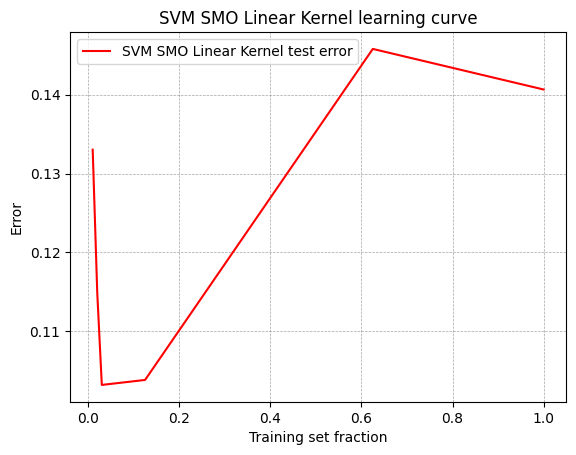

In [31]:
from src.svm import SVM_SMO
from src.kernels import LinearKernel
from src.measures import draw_learning_curve

training_set_fractions = [0.01, 0.02, 0.03, 0.125, 0.625, 1]

svm_smo = SVM_SMO(C=1.0, epochs=5000, kernel=LinearKernel(), silent=True)
draw_learning_curve([svm_smo], datasets, training_set_fractions, ['red'])

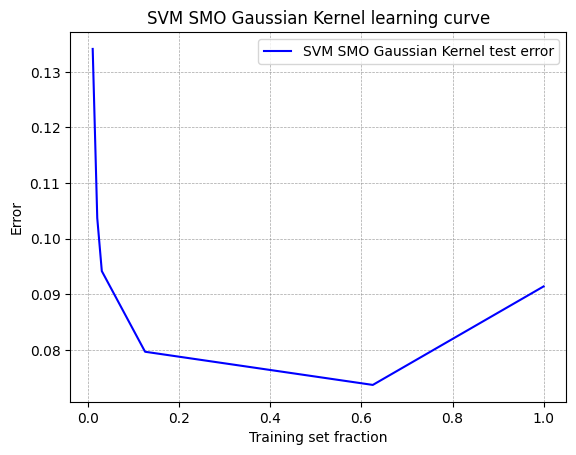

In [32]:
from src.svm import SVM_SMO
from src.kernels import GaussianKernel
from src.measures import draw_learning_curve

svm_smo_kernel = SVM_SMO(C=1.0, epochs=5000, kernel=GaussianKernel(sigma=7), silent=True)
draw_learning_curve([svm_smo_kernel], datasets, training_set_fractions, ['blue'])

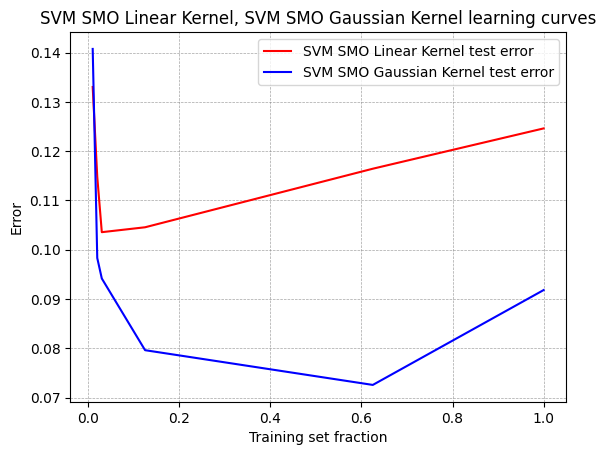

In [34]:
svm_smo = SVM_SMO(C=1.0, epochs=5000, kernel=LinearKernel(), silent=True)
svm_smo_kernel = SVM_SMO(C=1.0, epochs=5000, kernel=GaussianKernel(sigma=7), silent=True)
draw_learning_curve([svm_smo, svm_smo_kernel], datasets, training_set_fractions, ['red', 'blue'],)